# Grover's algorithm implementation in Rigetti Forest with arbitrary qubits

In the previous notebook we have seen how to implement the Grover's algorithm in the case of 2 qubits, corresponding to a database of $2^{2}=4$ elements.<br>
Now we want to extend to cases of 3 and <i>n</i> qubits.<br>

## 3 Qubits
If we want to obtain the element |111> we need to use a Controlled Controlled Z gate, which has the following matrix representation:<br><br>
$$ CCZ=
\begin{bmatrix}
1&0&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0\\
0&0&1&0&0&0&0&0\\
0&0&0&1&0&0&0&0\\
0&0&0&0&1&0&0&0\\
0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&-1
\end{bmatrix}
$$
It turns out that the CCZ gate is not available in Forest SDK, so it will have to be built combining other basic gates.<br>
According to <a href="https://quantumcomputing.stackexchange.com/a/2205">https://quantumcomputing.stackexchange.com/a/2205</a> it is required to combine multiple CNOT, T and DAGGER T gates as follows:
<img src="img/ccz.png" width="600">

In [77]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quilbase import DefGate
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from collections import Counter

qvm = get_qc('9q-square-qvm')
n_qubits = 3
qubits = list(range(n_qubits))

In [78]:
def ccz(p, qubits):
    p += CNOT(1, 2)
    p += RZ(-pi/4, 2) #DAGGER T
    p += CNOT(0, 2)
    p += T(2) # Equivalent to RZ(pi/4, 2)
    p += CNOT(1, 2)
    p += RZ(-pi/4, 2)
    p += CNOT(0, 2)
    p += T(1)
    p += T(2)
    p += CNOT(0, 1)
    p += RZ(-pi/4, 1)
    p += CNOT(0, 1)
    p += T(0)

In [79]:
def superposition(p, qubits):
    for qubit in qubits:
        p += H(qubit)
        
def oracle(p, qubits):
    ccz(p, qubits)

def phase_shift(p, qubits):
    for qubit in qubits:
        p += X(qubit)
    ccz(p, qubits)
    for qubit in qubits:
        p += X(qubit)

We will run the algorithm 100 times to better see the probability of finding the solutions.

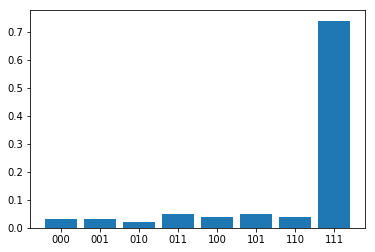

In [80]:
p = Program()
superposition(p, qubits)

oracle(p, qubits)

superposition(p, qubits)
phase_shift(p, qubits)
superposition(p, qubits)

p = p.measure_all()

p.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)

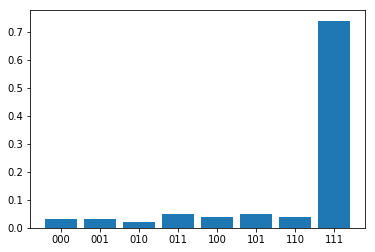

In [81]:
def plot_result(result, n_qubits):
    result_int = result.dot(2**np.arange(n_qubits)[::-1])
    int2binary = np.vectorize(np.binary_repr)
    result_string = int2binary(result_int, n_qubits)

    counts = Counter(result_string)
    bit_strings = int2binary(np.arange(0, 2**n_qubits), n_qubits)
    counts = [counts[bit_string] for bit_string in bit_strings]
    frequencies = [value/len(result_int) for value in counts]
    

    plt.bar(bit_strings, frequencies)
    plt.show()

plot_result(result, n_qubits)

We can observe that not all the results are equal to our solution |111>. That's because Grover's algorithm has to perform $round(\frac{\pi}{4}\sqrt{N})$ iterations to get a near-optimal probability of finding the solution.<br>
Hence, in this case, $round(2.2)= 2$ iterations are required.

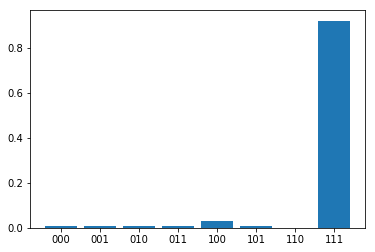

In [82]:
p = Program()
superposition(p, qubits)

for _ in range(2):
    oracle(p, qubits)

    superposition(p, qubits)
    phase_shift(p, qubits)
    superposition(p, qubits)

p = p.measure_all()

p.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)
plot_result(result, n_qubits)

The probability of finding the solution in two iterations is not exactly 1, in fact, we see that the number of correct results is greater than the one from a single iteration, but we still see some wrong results.

Notice that if we perform more than 2 iterations, the performance starts to worsen. So the algorithm doesn't follow the principle that the more iterations are performed, the better is the result.

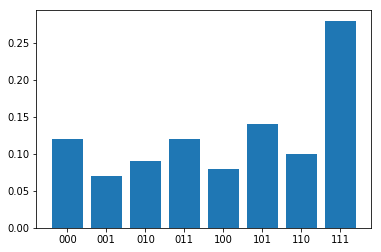

In [83]:
p = Program()
superposition(p, qubits)

for _ in range(3):
    oracle(p, qubits)

    superposition(p, qubits)
    phase_shift(p, qubits)
    superposition(p, qubits)

p = p.measure_all()

p.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)
plot_result(result, n_qubits)

## Finding arbitrary solutions
Up to now, to simplify the problem, we have always considered cases in which the solution was |11> or |111>, because the corresponding oracle was respectively the CZ and CCZ gate.<br>
But what if we want to search for other elements of the database?

There are two techniques to design the oracle operator, as described in <a href="https://arxiv.org/pdf/1703.10535.pdf">Complete 3-Qubit Grover Search on a Programmable Quantum Computer</a>: the <b>boolean oracle</b> and the <b>phase oracle</b>.<br>
The former is the most straightforward, because it is based on the same principles of the boolean algebra, but it needs one qubit more (called ancilla qubit) than the latter.<br>
In the previous examples we have always used the phase oracle, so, if we would like to search for different solutions (e.g. |10>) we would have to use oracles whose combination of gates is not very intuitive (e.g. S(0), CZ(0,1) and S(0) in the case of |10>).

For this reason the boolean oracles will be used for the next example: the oracle is composed by a NOT whose target is the ancilla qubit and the control are all the other qubits. The qubits whose corresponding value of the solution is 0 (e.g. the first qubit for the solution |011>) are surronded by an X gate (which is equivalent to a NOT). In this way the ancilla qubit will flip, set initially to |1>, will flip only when the control qubits, or their negation if surronded by X gates, are equal to 1.

Let's consider the oracle for the solution |011>:
<img src="img/boolean.png">

The gate between the two X gates is the CCCNOT (Triple controlled NOT).<br>
Similarly to what happened for the CCZ gate, the CCCNOT gate is not available in the Forest SDK, but in this case, instead of using an equivalent combination of fundamental gates, we will use a useful SDK's feature: <b>defining new gates</b>.<br>
By using <b>DefGate()</b> we can create new gates based on their matrix representation. This feature is available only for the Quantum Virtual Machine, because in a real computer we are restricted to use fundamental gates or their combination.<br>
The CCCNOT gate is represented by the matrix:<br><br>
$$ CCCNOT =
\begin{bmatrix}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0
\end{bmatrix}
$$

In [84]:
p = Program()
# Add the ancilla qubit
n_qubits = 4
qubits = list(range(n_qubits))

# Number of elements
N = 2 ** n_qubits

# Initialize a matrix of zeros with size NxN
cccnot = np.zeros(shape=(N, N))

# Set the main diagonal equal to 1, except for the last 2 elements
for q in range(N-2):
    cccnot[q, q] = 1

# Set the elements of the NOT operator
cccnot[N-2, N-1] = 1
cccnot[N-1, N-2] = 1
print(cccnot)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [85]:
cccnot_definition = DefGate("CCCNOT", cccnot)

#Remember to add the gate definition to the program
p += cccnot_definition
CCCNOT = cccnot_definition.get_constructor()

Now we can use CCCNOT in the same way as the other predefined gates.<br>
Let's implement the circuit.

In [86]:
# Set the ancilla qubit to 1
p += X(3)
superposition(p, qubits)

for _ in range(2):
    #Oracle
    p += X(0)
    p += CCCNOT(*qubits)
    p += X(0)

    #Diffusion
    superposition(p, qubits)
    phase_shift(p, qubits[:-1]) # Exclude the ancilla from the phase shift
    superposition(p, qubits[:-1])

In this case we don't want to measure the ancilla qubit, so, instead of using the function measure_all() we will have to manually declare a memory space of 3 qubits and add the three desired measure gates.

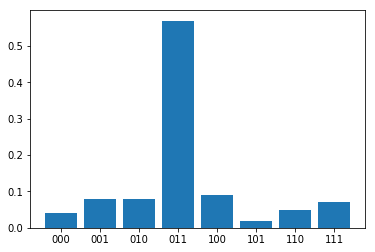

In [87]:
ro = p.declare('ro', 'BIT', 3)
p += MEASURE(0, ro[0])
p += MEASURE(1, ro[1])
p += MEASURE(2, ro[2])
p.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)
plot_result(result, n_qubits-1) #Don't consider the ancilla qubit

We iterated 2 times the oracle and diffusion operators, but even if we see a prevalence of |011> states, they are not in the same proportion as in the previous execution. Why?<br>
That's because of the ancilla qubit: we need a new "clean" one for each iteration.<br>
Let's try to use 3 normal qubits and 2 ancilla qubits and using different ancilla qubits at each iteration.

In [88]:
n_qubits = 5
qubits = list(range(n_qubits))

p = Program()
p += cccnot_definition

# Set the ancilla qubits to 1
p += X(3)
p += X(4)
superposition(p, qubits)

## Iteration 1
#Oracle
p += X(0)
p += CCCNOT(0,1,2,3)
p += X(0)

#Diffusion
superposition(p, [0,1,2,3])
phase_shift(p, [0,1,2])
superposition(p, [0,1,2])

## Iteration 2
#Oracle
p += X(0)
p += CCCNOT(0,1,2,4)
p += X(0)

#Diffusion
superposition(p, [0,1,2,4])
phase_shift(p, [0,1,2])
superposition(p, [0,1,2])

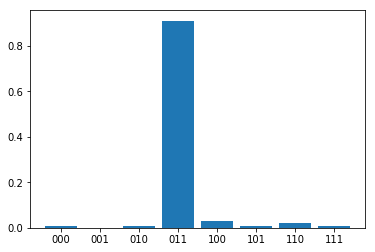

In [89]:
ro = p.declare('ro', 'BIT', 3)
p += MEASURE(0, ro[0])
p += MEASURE(1, ro[1])
p += MEASURE(2, ro[2])
p.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)
plot_result(result, n_qubits-2)

## n Qubits
Notice that the definition of the Controlled NOT gate using the matrix representation is general and allows the use of the gate with an arbitrary number of control qubits.<br>
The same principle can be applied to the Controlled Z required to perform the phase shift in the diffusion operator.<br>
In this way it is possible to execute (only in the simulated environment of the Quantum Virtual Machine) the Grover's algorithm with an arbitrary number of qubits. 